# WGAN-GP Training

## imports

In [ ]:
%matplotlib inline

import os
import matplotlib.pyplot as plt

from models.WGANGP import WGANGP
from utils.loaders import load_dataset

import pickle
import tensorflow as tf

Masking Test

In [ ]:
""" import cv2
import numpy as np

# Load image, create mask, and draw white circle on mask
image = cv2.imread('data/dataset128/dataset128/55.png')
mask = np.zeros(image.shape, dtype=np.uint8)
mask = cv2.circle(mask, (64, 64), 20, (255,255,255), -1) 

# Mask input image with binary mask
mask = cv2.bitwise_not(mask)
result = cv2.bitwise_and(image, mask)
# Color background white
result[mask==0] = 255 # Optional

cv2.imshow('image', image)
cv2.imshow('mask', mask)
cv2.imshow('result', result)
cv2.waitKey()
cv2.destroyAllWindows() """

In [ ]:
""" import cv2
import os
import numpy as np


def read_path(file_pathname):

    # Traverse all the pictures in the folder
    for filename in os.listdir(file_pathname):
        
        print(filename)  # Print picture name
        a = 44  # Set the initial edge position of the mask area
        img = cv2.imread(file_pathname+'/'+filename)  # Read the picture
        # 255： Generate all white numerical matrix （ If you want to generate a black area block ,
        mask = np.zeros(img.shape, dtype=np.uint8) 
        # Need generation 0 matrix .）
        # The mask area size is 40×40, Let the pixel value of this area be 0（ black ）
        mask[a:a + 40, a:a + 40] = 255
        # cv2.bitwise_and It's about binary data “ And ” operation ,
        mask = cv2.bitwise_not(mask)
        mask_img = cv2.bitwise_and(img, mask)
        mask_img[mask==0] = 255
        # The white area of the mask image is reserved for the image pixels to be processed , The black area is the elimination of the image pixels to be processed
        # Save the image to the specified location
        cv2.imwrite("/Users/leogenot/Desktop/DeepDrawingGeneration-WGAN-GP/data/dataset128masked/"+filename, mask_img)
read_path("/Users/leogenot/Desktop/DeepDrawingGeneration-WGAN-GP/data/dataset128tomask/dataset128") """


In [ ]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'dataset128'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

## data

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [ ]:
x_train = load_dataset(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)

In [ ]:
x_train[0][0][0]

In [ ]:
plt.imshow((x_train[0][0][0]))

## architecture

In [ ]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,1)
        , critic_conv_filters = [128,256,512,1024]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (8, 8, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [512,256,128,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))


In [ ]:
gan.critic.summary()

In [ ]:
gan.generator.summary()

## training

In [ ]:
EPOCHS = 6501
PRINT_EVERY_N_BATCHES = 500
N_CRITIC = 5
BATCH_SIZE = 16

In [ ]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()


Make gif of data

In [ ]:
import imageio
import glob

out_file = 'generated_data.gif'

with imageio.get_writer(out_file, mode='I', duration=0.3) as writer:
    file_names = glob.glob(os.path.join(RUN_FOLDER, 'images') + '/*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

from IPython.display import Image
Image(open('generated_data.gif','rb').read())

In [ ]:

loaded_model = tf.keras.models.load_model( "run/gan/0003_dataset64/model.h5", compile = False )
loaded_model.predict("data/dataset64/dataset64")

2022-01-24 12:19:07.836365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


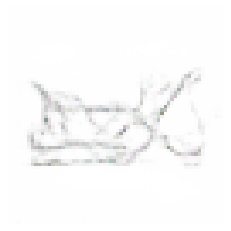

In [7]:
# example of loading the generator model and generating images
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import numpy as np

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :], cmap="gray")
  		##pyplot.imshow(examples[i, :], cmap="gray")
  		
	pyplot.show()

# load model
model = load_model("run/gan/0003_dataset64/generator.h5")
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 1)